<a href="https://colab.research.google.com/github/anagabrielaoliveira/bike-sharing-demand-forecasting/blob/main/bike_sharing_demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Problem Description

https://www.kaggle.com/competitions/bike-sharing-demand/overview

Predict casual, registered, and count values.

Available Information:

I) *datetime* - hourly date + timestamp  

*season* - nominal categorical, originally coded as:
*   1 = spring
*   2 = summer
*   3 = fall
*   4 = winter

Considering that the rentals are in Washington DC, the correct interpretation of the codes is:
*   1 = winter
*   2 = spring
*   3 = summer
*   4 = fall

II) *holiday* - whether the day is considered a holiday - binary

III)*workingday* - whether the day is neither a weekend nor holiday - binary

IV) *weather* - ordinal categorical
*   1: Clear, Few clouds, Partly cloudy, Partly cloudy
*   2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
*   3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
*   4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

V) *temp* - temperature in Celsius - *continuos quantitative*

VI) *atemp* - "feels like" temperature - *continuous quantitative*

VII) *humidity* - relative humidity - *continuos quantitative*

VIII) *windspeed* - wind speed - *continuos quantitative*

Targets to predict:

I) *casual* - number of non-registered user rentals initiated - *discrete quantitative*

II) *registered* - number of registered user rentals initiated - *discrete quantitative*

III) *count* - number of total rentals - *discrete quantitative*


#2. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import processing

# Frameworks / Optimization
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
#!pip install optuna
import optuna

# Scikit-learn
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.multioutput import MultiOutputRegressor
from sklearn.base import clone

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error

# 3. Data Loading

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#df_file_path = '/content/drive/MyDrive/DATA_PROJECTS/bike-sharing-demand/train.csv'
#df_file_path_test = '/content/drive/MyDrive/DATA_PROJECTS/bike-sharing-demand/test.csv'

#df_train = pd.read_csv(df_file_path)
#df_test = pd.read_csv(df_file_path_test)

df_file_path = 'data/train.csv'
df_file_path_test = 'data/test.csv'

df_train = pd.read_csv(df_file_path)
df_test = pd.read_csv(df_file_path_test)

# 4. Data Overview
Checking column types, missing values, basic statistics

In [4]:
df_train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [5]:
df_test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')

In [6]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [8]:
# Descriptive statistics for quantitative features
df_train[['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']].describe()

,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [9]:
total_missing = df_train.isnull().sum()
total_missing

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [10]:
total_zeros = (df_train == 0).sum()
total_zeros

datetime          0
season            0
holiday       10575
workingday     3474
weather           0
temp              0
atemp             0
humidity         22
windspeed      1313
casual          986
registered       15
count             0
dtype: int64

In [11]:
total_zeros = (df_test == 0).sum()
total_zeros

datetime         0
season           0
holiday       6304
workingday    2040
weather          0
temp             0
atemp            2
humidity         0
windspeed      867
dtype: int64

# 5. Baseline

Data Preparation for the baseline, model training (Random Forest), residual and bias analysis

In [12]:
df_train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [13]:
# Converting 'datetime' column to datetime type in both dfs
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_test['datetime'] = pd.to_datetime(df_test['datetime'])

# Setting as the index
df_train.set_index('datetime', inplace=True)
df_test.set_index('datetime', inplace=True)

df_train.sort_index(inplace=True)
df_test.sort_index(inplace=True)

In [14]:
df_train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [15]:
quantitative_cols = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']
df_train[quantitative_cols].skew()

temp          0.003691
atemp        -0.102560
humidity     -0.086335
windspeed     0.588767
casual        2.495748
registered    1.524805
count         1.242066
dtype: float64

In [16]:
# tree-based models were chosen because they are robust to skewed distributions,
# though extreme skew may still cause imbalanced partitions

df_train_X = df_train.drop(['casual', 'registered', 'count' ], axis=1)

In [17]:
# Training baselines for each target variable
y_test_reg, y_pred_reg = processing.train_rf_model(df_train_X, df_train[['registered']])
y_test_cas, y_pred_cas = processing.train_rf_model(df_train_X, df_train[['casual']])
y_test_cnt, y_pred_cnt = processing.train_rf_model(df_train_X, df_train[['count']])

Text(0.5, 1.0, 'Residuals vs Predicted — Registered (Random Forest)')

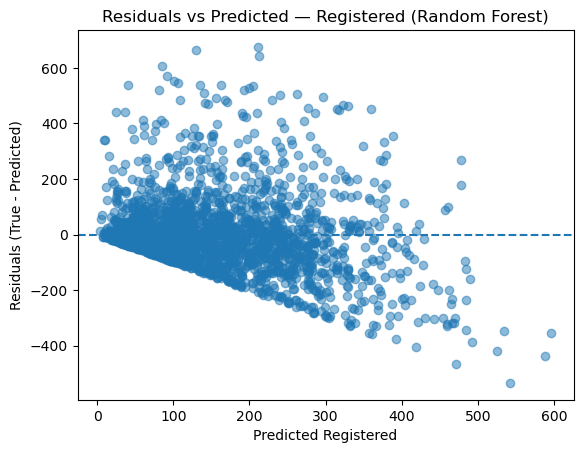

In [18]:
# Residuals REGISTERED Baseline
residuals_reg = y_test_reg - y_pred_reg

plt.scatter(y_pred_reg, residuals_reg, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel('Predicted Registered')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residuals vs Predicted — Registered (Random Forest)')

Text(0.5, 1.0, 'Residuals vs Predicted — Casual (Random Forest)')

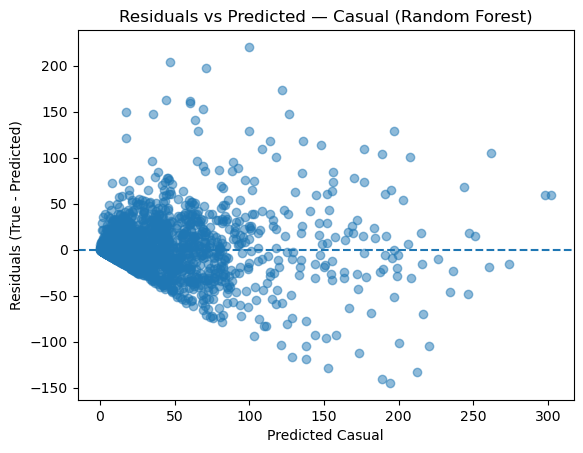

In [19]:
# Residuals CASUAL Baseline
residuals_cas = y_test_cas - y_pred_cas

plt.scatter(y_pred_cas, residuals_cas, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel('Predicted Casual')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residuals vs Predicted — Casual (Random Forest)')

Text(0.5, 1.0, 'Residuals vs Predicted — Count (Random Forest)')

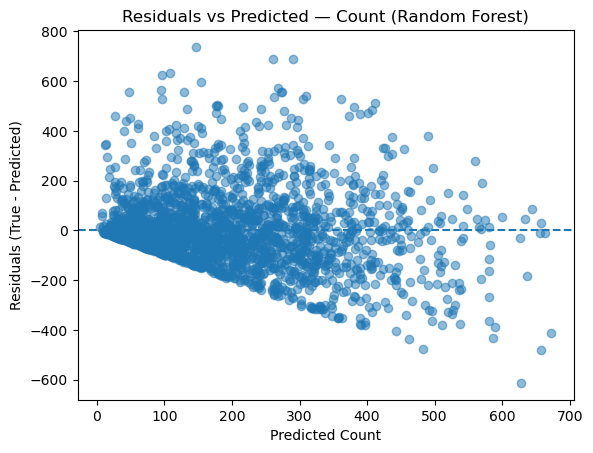

In [20]:
# Residuals COUNT Baseline
residuals_cnt = y_test_cnt - y_pred_cnt

plt.scatter(y_pred_cnt, residuals_cnt, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel('Predicted Count')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residuals vs Predicted — Count (Random Forest)')

In [21]:
# The funnel shape indicates that low values are overestimated and high values
# are scattered all over

[]

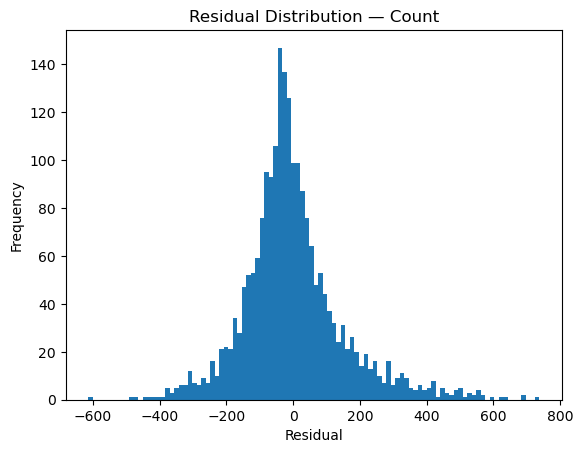

In [22]:
# Residual Distribution COUNT
plt.hist(residuals_cnt, bins=100)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Distribution — Count')
plt.plot()

# The residual distribution is centered near zero, indicating minimal overall bias

## 6 Preprocessing / Feature Engineering



### 6.1 Data Validation and Consistency Checks

In [23]:
# Filter rows where the sum of casual and registered does not equal count
invalid_rows = df_train[df_train['casual'] + df_train['registered'] != df_train['count']]
print(invalid_rows[['casual', 'registered', 'count']])

Empty DataFrame
Columns: [casual, registered, count]
Index: []


In [24]:
columns_to_check = ['season', 'holiday', 'workingday', 'weather']
processing.unique_values(columns_to_check, df_train)

season: [1 2 3 4]

holiday: [0 1]

workingday: [0 1]

weather: [1 2 3 4]



### 6.2 Temporal Structuring and Feature Engineering

In [25]:
# Defining special holidays
# Purpose: later use for creating a binary feature indicating special holidays
special_holidays = [

    # Christmas
    '2011-12-24', '2011-12-25', '2011-12-26',  # 26th - observance
    '2012-12-24', '2012-12-25',

    # New Year's Eve & New Year
    '2011-01-01', '2011-12-31', '2012-01-01',
    '2012-12-31',

    # Hurricane Sandy
    '2012-10-29', '2012-10-30'
]

special_holidays = [pd.to_datetime(d).date() for d in special_holidays]

In [26]:
# Usa função create-time_features para criar variavei temporais a partir do datetime
df_with_time_features_train = processing.create_time_features(df_train, special_holidays)
df_with_time_features_test  = processing.create_time_features(df_test, special_holidays)

In [27]:
# Updating workingday and holiday for special holidays on training and test sets
cols_to_update = ['workingday', 'holiday']

df_with_time_features_train.loc[df_with_time_features_train['special_holiday'] == 1, cols_to_update] = [0, 1]
df_with_time_features_test.loc[df_with_time_features_test['special_holiday'] == 1, cols_to_update] = [0, 1]

###6.3 Temporal Data Consistency and Coverage

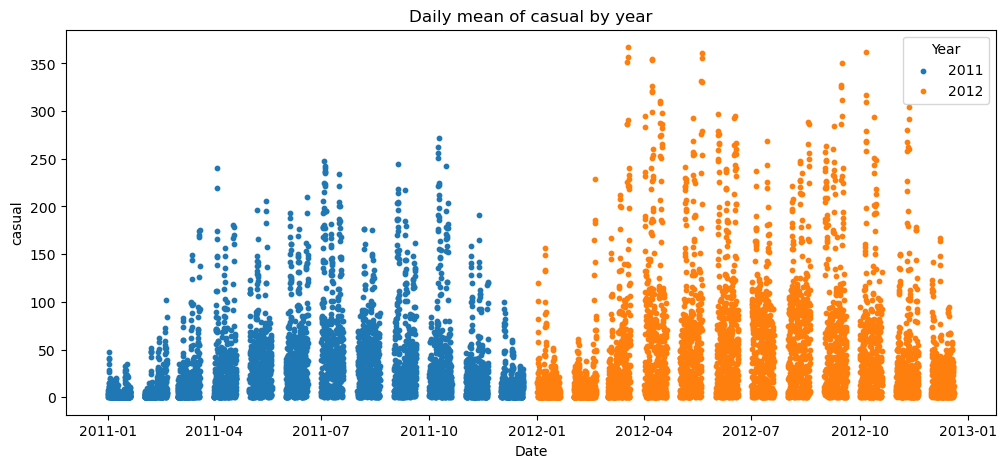

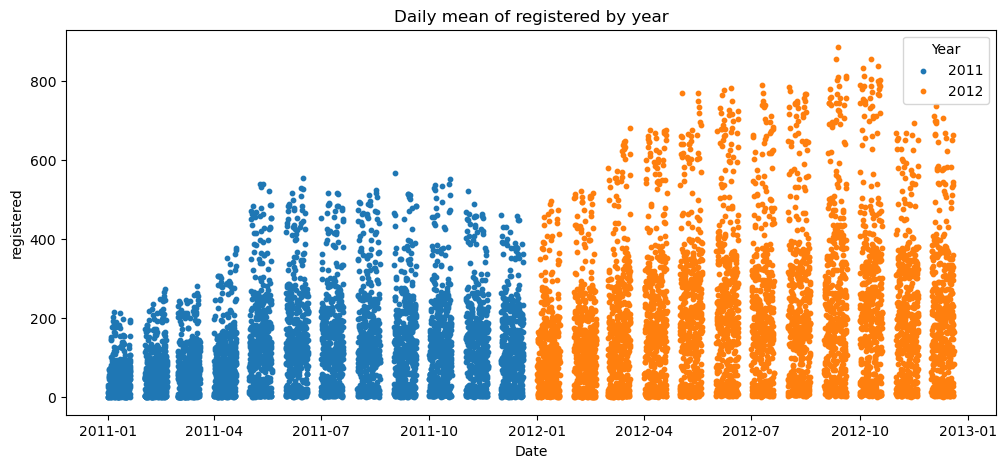

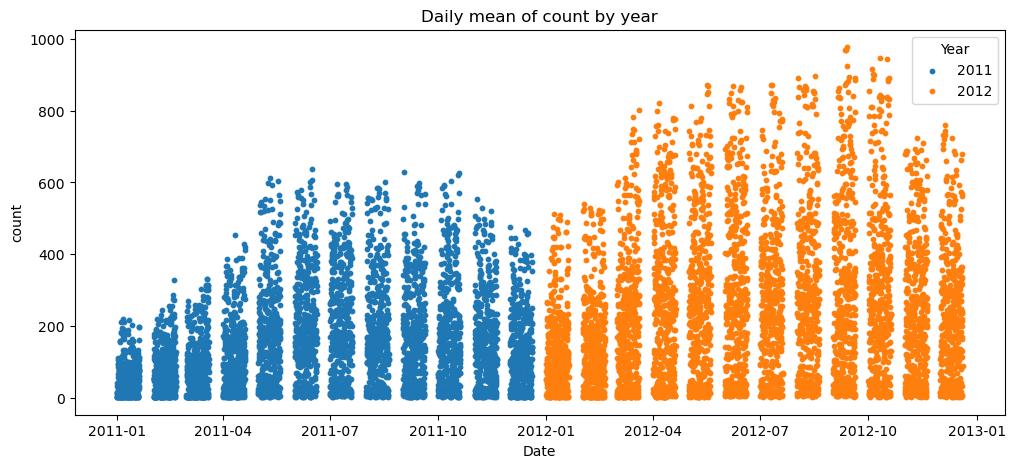

In [28]:
# Usa função para ver a média diaria por dia do meu df treino e dados faltantes que devem ser previstos
processing.plot_daily_by_year(df_train, 'casual')
processing.plot_daily_by_year(df_train, 'registered')
processing.plot_daily_by_year(df_train, 'count')

In [29]:
# Aggregate data by month
hours_per_month = df_test.groupby(df_test.index.to_period('M')).size()

# Convert total hours into days and remaining hours
days = (hours_per_month // 24).astype(int)
hours = (hours_per_month % 24).astype(int)

# Create a summary DataFrame
result = hours_per_month.to_frame(name="total_hours")
result["days"] = days
result["hours"] = hours

print(result)

          total_hours  days  hours
datetime                          
2011-01           257    10     17
2011-02           203     8     11
2011-03           284    11     20
2011-04           264    11      0
2011-05           288    12      0
2011-06           264    11      0
2011-07           288    12      0
2011-08           275    11     11
2011-09           264    11      0
2011-10           288    12      0
2011-11           263    10     23
2011-12           285    11     21
2012-01           288    12      0
2012-02           237     9     21
2012-03           288    12      0
2012-04           264    11      0
2012-05           288    12      0
2012-06           264    11      0
2012-07           288    12      0
2012-08           288    12      0
2012-09           264    11      0
2012-10           252    10     12
2012-11           263    10     23
2012-12           286    11     22


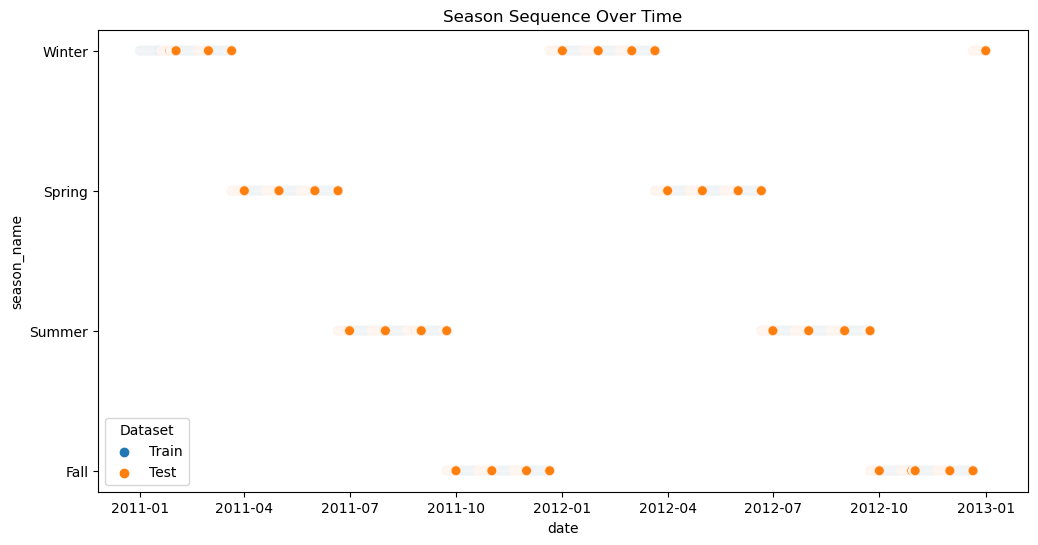

In [30]:
# Verifying if season follows a chronological sequence
# across both training and testing datasets to prevent data misalignment

# Map numeric seasons to names
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df_train['season_name'] = df_train['season'].map(season_map)
df_test['season_name'] = df_test['season'].map(season_map)

# Combine train and test with a column to identify them
df_train_plot = df_train[['season_name']].copy()
df_train_plot['dataset'] = 'Train'
df_train_plot['date'] = df_train.index

df_test_plot = df_test[['season_name']].copy()
df_test_plot['dataset'] = 'Test'
df_test_plot['date'] = df_test.index

df_plot = pd.concat([df_train_plot, df_test_plot])

# Plot
plt.figure(figsize=(12,6))
sns.scatterplot(data=df_plot, x='date', y='season_name', hue='dataset', alpha=0.6, s=50)
plt.title('Season Sequence Over Time')
plt.legend(title='Dataset')

###6.4 Categorical Variable Quality and Handling

In [31]:
print("Weather distribution:")
print(df_train["weather"].value_counts())

print("\nSeason distribution:")
print(df_train["season"].value_counts())

Weather distribution:
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

Season distribution:
4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64


In [32]:
# Looking when weather = 4.
weather_4 = df_with_time_features_train[df_with_time_features_train['weather'] == 4]
weather_4

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,dayofweek,dayofmonth,dayofyear,weekofyear,month,quarter,year,weekend,date,special_holiday
datetime,,,,,,,,,,,,,,,,,,,,,
2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,6,158,...,0,9,9,2,1,1,2012,0,2012-01-09,0


In [33]:
df_with_time_features_train.loc['2012-01-09 16:00:00':'2012-01-09 20:00:00']
# Looking at the day, this makes sense due to the humidity and the weather evaluation
# changing from 3 to 4 and then back to 3.

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,dayofweek,dayofmonth,dayofyear,weekofyear,month,quarter,year,weekend,date,special_holiday
datetime,,,,,,,,,,,,,,,,,,,,,
2012-01-09 16:00:00,1,0,1,3,9.02,12.880,87,6.0032,3,46,...,0,9,9,2,1,1,2012,0,2012-01-09,0
2012-01-09 17:00:00,1,0,1,3,9.02,13.635,87,0.0000,5,147,...,0,9,9,2,1,1,2012,0,2012-01-09,0
2012-01-09 18:00:00,1,0,1,4,8.20,11.365,86,6.0032,6,158,...,0,9,9,2,1,1,2012,0,2012-01-09,0
2012-01-09 19:00:00,1,0,1,3,8.20,11.365,93,6.0032,3,187,...,0,9,9,2,1,1,2012,0,2012-01-09,0
2012-01-09 20:00:00,1,0,1,2,8.20,11.365,86,6.0032,5,127,...,0,9,9,2,1,1,2012,0,2012-01-09,0


In [34]:
# There are few observations with weather =4, so we group them into category 3
# Rare categories introduce high variance and unstable patters during training,
# especially in tree-based models

df_with_time_features_train.loc[df_with_time_features_train['weather'] == 4, 'weather'] = 3
df_with_time_features_test.loc[df_with_time_features_test['weather'] == 4, 'weather'] = 3

###6.5 Forecast-Oriented Exploratory Data Analysis



Text(0.5, 1.0, 'Average Rentals on Holidays')

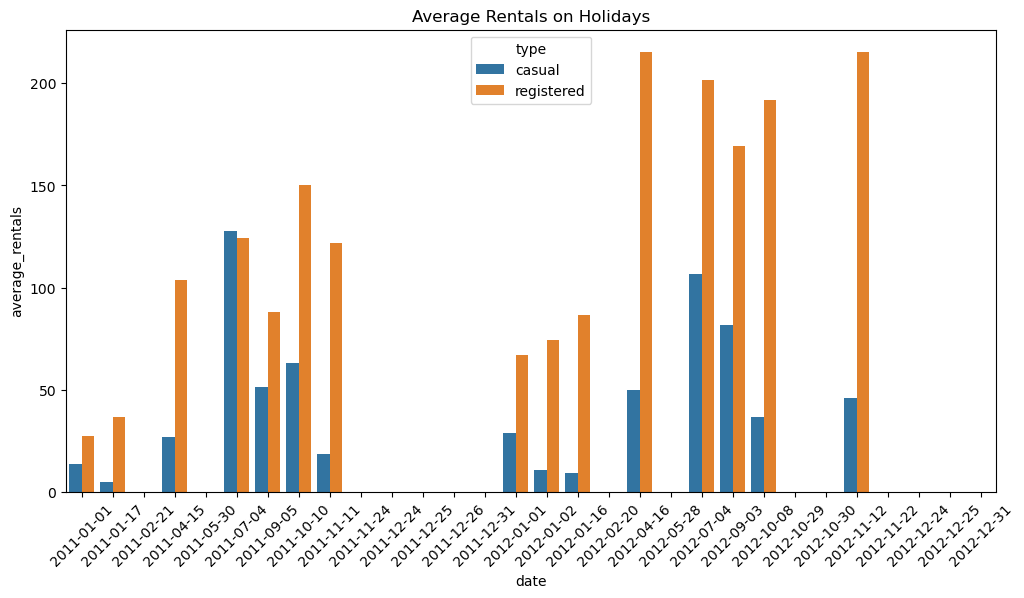

In [35]:
df_concat = pd.concat([df_with_time_features_train, df_with_time_features_test], sort=False)
df_concat.sort_index(inplace=True)

# Filter only holidays and calculate daily mean
mean_by_day = df_concat[df_concat['holiday'] == 1][['casual','registered']]
mean_by_day = mean_by_day.groupby(mean_by_day.index.date).mean().reset_index()
mean_by_day.rename(columns={'index': 'date'}, inplace=True)

# Melt for seaborn
mean_by_day = mean_by_day.melt(id_vars='date', var_name='type', value_name='average_rentals')

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=mean_by_day, x='date', y='average_rentals', hue='type')
plt.xticks(rotation=45)
plt.title('Average Rentals on Holidays')

# For some holidays, i dont have rental data, like Christmas

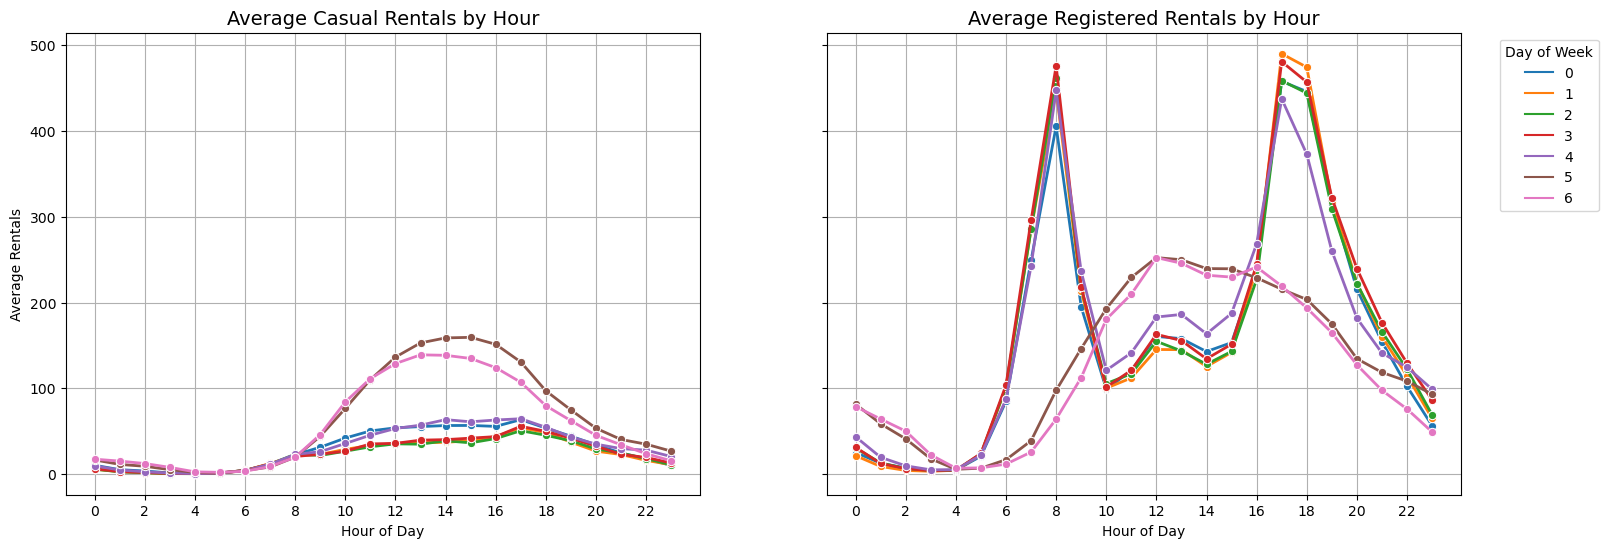

In [36]:
# Grouping by day of the week and hour
dayofweek_avg = (
    df_with_time_features_train
    .groupby(['dayofweek','hour'])[['casual','registered']]
    .mean()
    .reset_index()
)

fig, axes = plt.subplots(1, 2, figsize=(18,6), sharey=True)

# Casual
sns.lineplot(
    data=dayofweek_avg,
    x='hour',
    y='casual',
    hue='dayofweek',
    marker='o',
    linewidth=2,
    ax=axes[0],
    palette="tab10"
)
axes[0].set_title('Average Casual Rentals by Hour', fontsize=14)
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Average Rentals')
axes[0].set_xticks(range(0,24,2))
axes[0].grid(True)

# Registered
sns.lineplot(
    data=dayofweek_avg,
    x='hour',
    y='registered',
    hue='dayofweek',
    marker='o',
    linewidth=2,
    ax=axes[1],
    palette="tab10"
)
axes[1].set_title('Average Registered Rentals by Hour', fontsize=14)
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('')
axes[1].set_xticks(range(0,24,2))
axes[1].grid(True)

# Legend
axes[1].legend(title='Day of Week', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].legend_.remove()  # Remove legend from first subplot

# Cant use those informations for feature engineering - data leakage

###6.6 Interaction Analysis and Feature Engineering

In [37]:
#categorical_cols = [ 'season', 'weather']
quantitative_independent_cols = [col for col in quantitative_cols
                              if col not in ['casual', 'registered', 'count']]
#binary_cols = ['holiday', 'workingday']

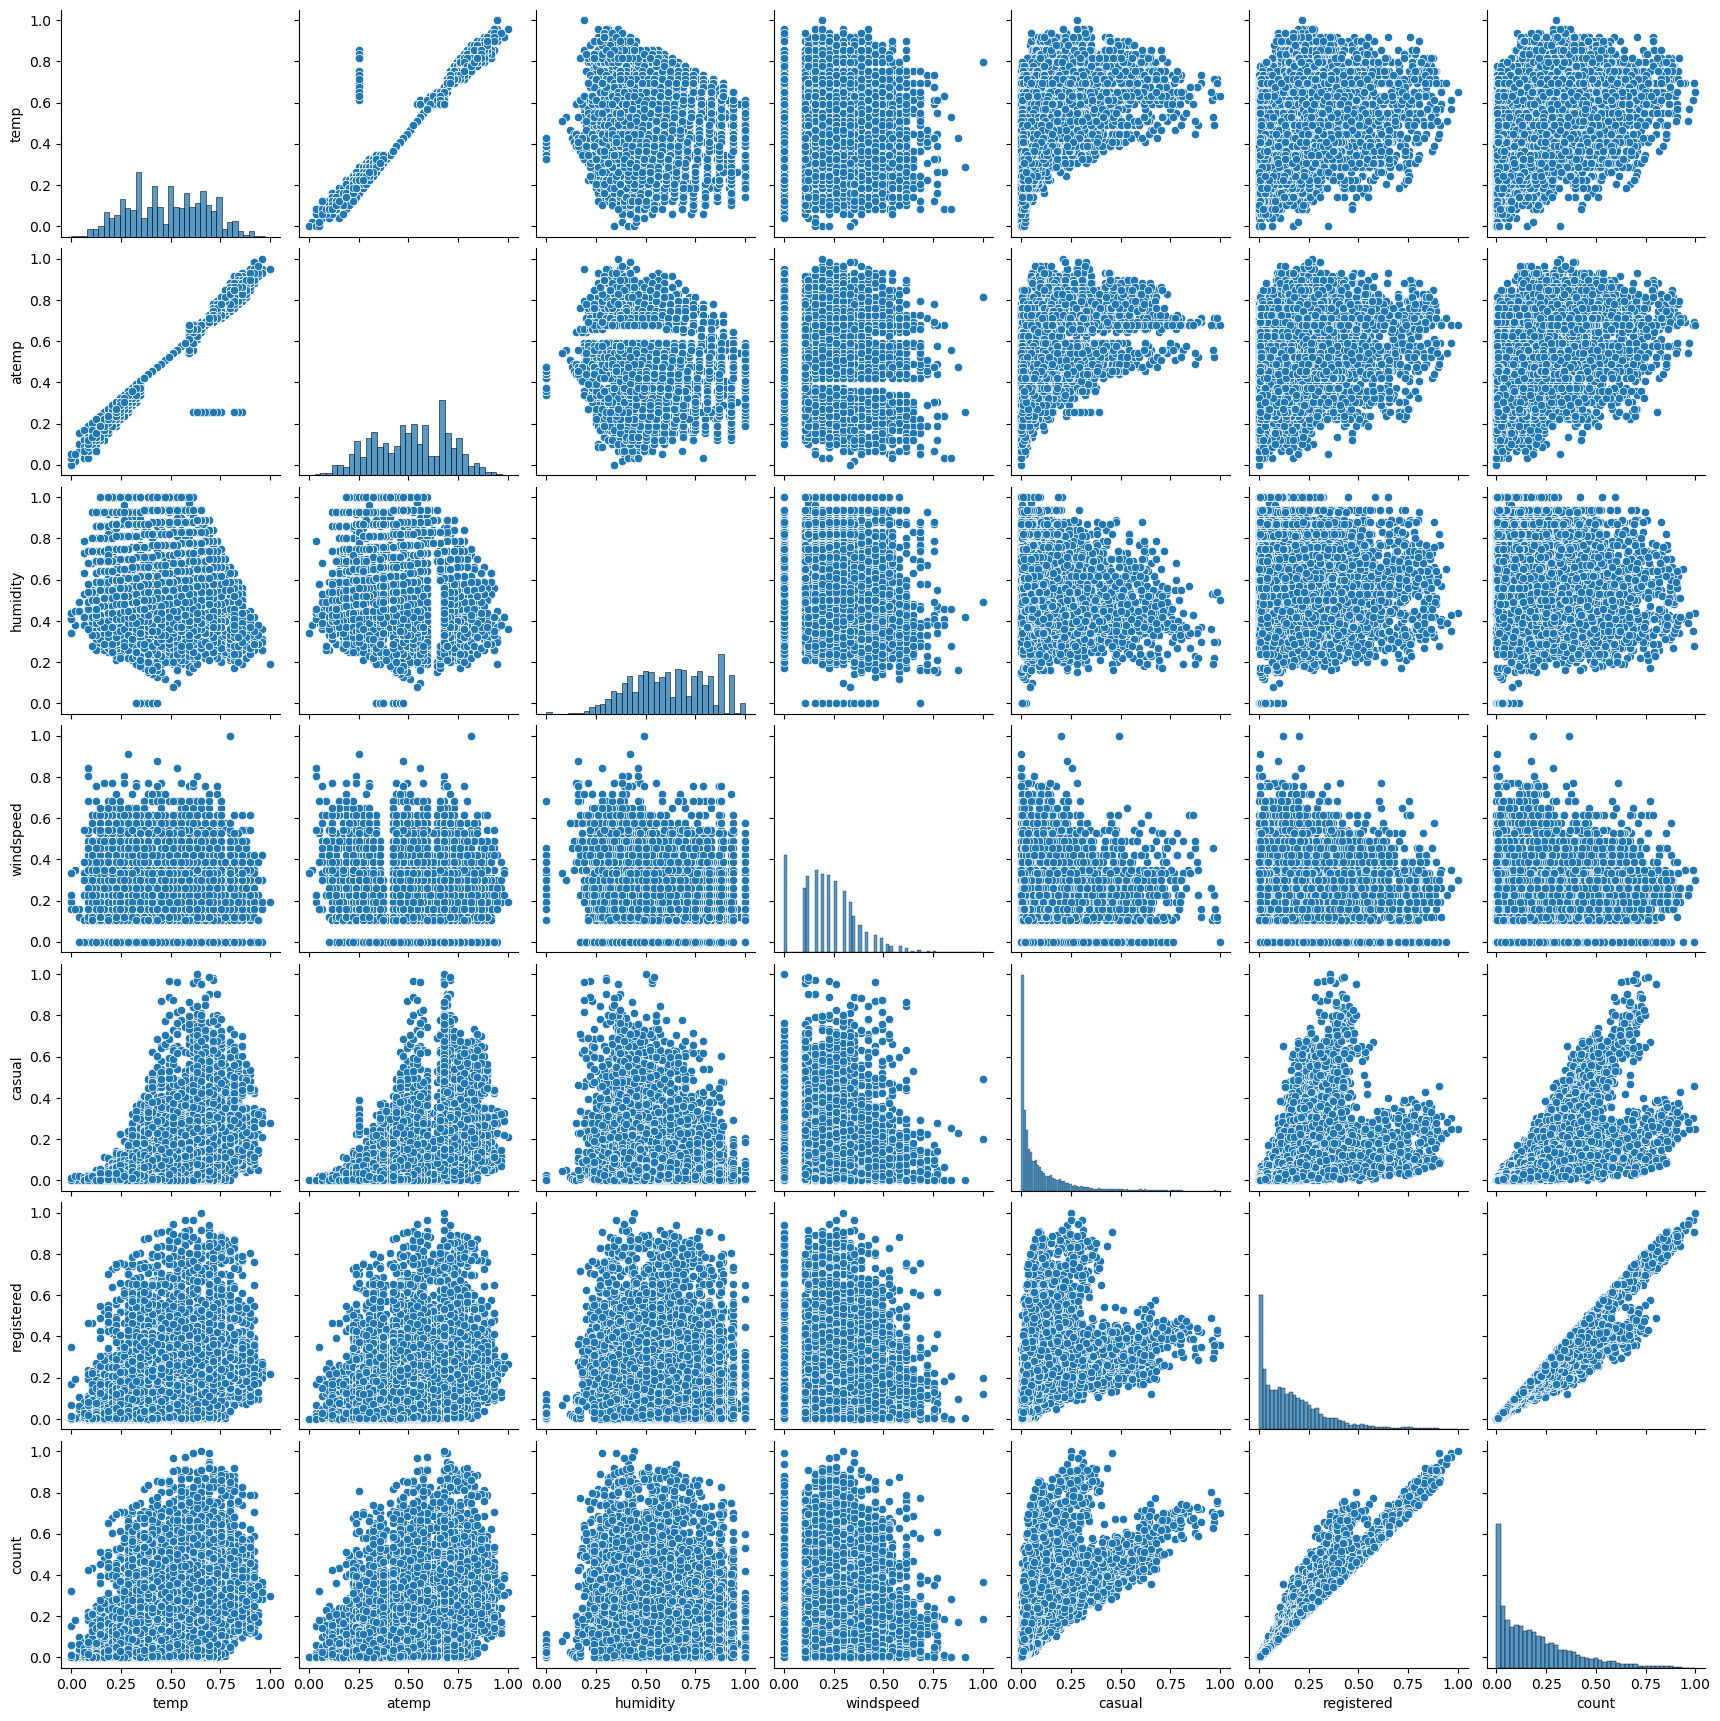

In [38]:
df_scaled = df_train[quantitative_cols].copy()

# Scale the features
scaler = MinMaxScaler()
df_scaled[quantitative_cols] = scaler.fit_transform(df_scaled[quantitative_cols])

# Pairplot
sns.pairplot(df_scaled)

#Skewed distributions: median < mean for casual, registered and count,
# indicating right-skewed distributions - they are less frequent and more
# spread out, while to the left of the median we have most of the values,
# more concentrated

In [39]:
# Exploring interations
df_with_time_features_train['temp_vs_humidity'] = df_with_time_features_train['temp'] * df_with_time_features_train['humidity']
df_with_time_features_train['temp_vs_windspeed'] = df_with_time_features_train['temp'] * df_with_time_features_train['windspeed']
df_with_time_features_train['humidity_vs_windspeed'] = df_with_time_features_train['humidity'] * df_with_time_features_train['windspeed']

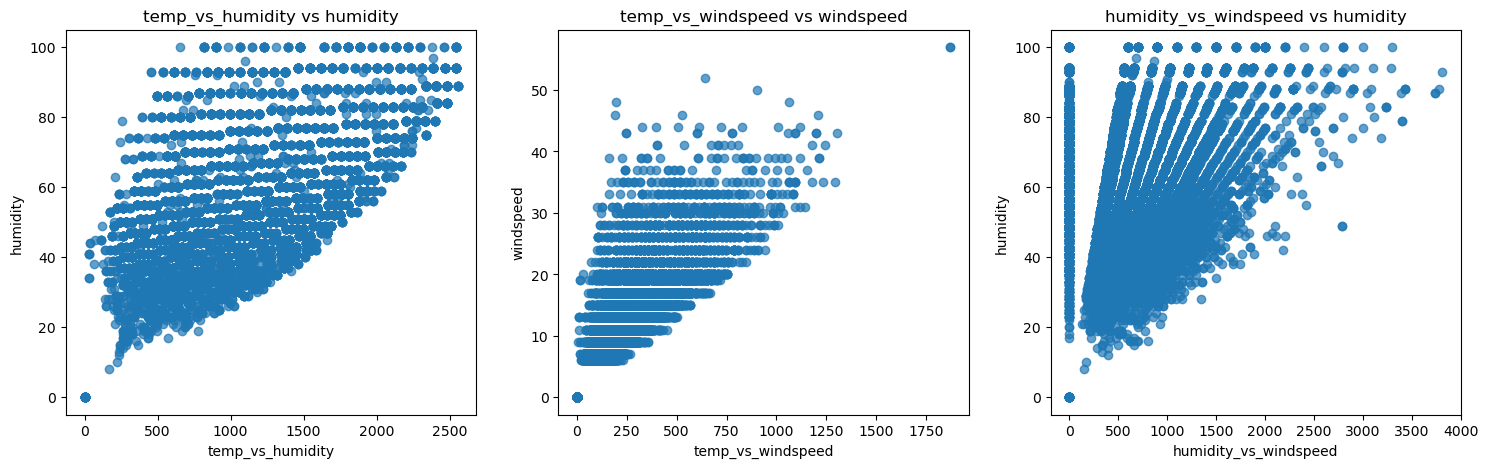

In [40]:
scatter_pairs = [
    ('temp_vs_humidity', 'humidity'),
    ('temp_vs_windspeed', 'windspeed'),
    ('humidity_vs_windspeed', 'humidity')
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (x_col, y_col) in zip(axes, scatter_pairs):
    ax.scatter(df_with_time_features_train[x_col], df_with_time_features_train[y_col], alpha=0.7)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f'{x_col} vs {y_col}')

In [41]:
# The main idea is to create feature based on hourly peaks. However, even though peaks are identified
# using only the training df, this still results in data leakage.
# Therefore, peak-based features should rely on external knowledge
# On working days, commuting ppeaks typically occur in the morning 7-9 and evenign 17-19

df_with_time_features_train['peak'] = processing.create_peak_feature(df_with_time_features_train)
df_with_time_features_test['peak'] = processing.create_peak_feature(df_with_time_features_test)

In [42]:
# Classification by time slots

df_with_time_features_train['time_group'] = processing.create_time_slots(df_with_time_features_train)
df_with_time_features_test['time_group'] = processing.create_time_slots(df_with_time_features_test)

#7. Outlier Removal

In [43]:
# Looking at the outlier in the windspeed vs. temp_vs_windspeed graph above
filtered_1 = df_with_time_features_train[(df_with_time_features_train['temp_vs_windspeed'] > 1750)]
filtered_1

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,quarter,year,weekend,date,special_holiday,temp_vs_humidity,temp_vs_windspeed,humidity_vs_windspeed,peak,time_group
datetime,,,,,,,,,,,,,,,,,,,,,
2011-07-03 17:00:00,3,0,0,3,32.8,37.12,49,56.9969,181,177,...,3,2011,1,2011-07-03,0,1607.2,1869.49832,2792.8481,0,6
2011-07-03 18:00:00,3,0,0,3,32.8,37.12,49,56.9969,74,107,...,3,2011,1,2011-07-03,0,1607.2,1869.49832,2792.8481,0,7


In [44]:
# The outlier observed in the humidity vs. humidity_vs_windspeed graph
# is the same as in the windspeed vs. temp_vs_windspeed graph.
filtered_2 = df_with_time_features_train[
    (df_with_time_features_train['humidity_vs_windspeed'] > 2600) &
    (df_with_time_features_train['humidity_vs_windspeed'] < 3000) &
    (df_with_time_features_train['windspeed'] > 43) &
    (df_with_time_features_train['windspeed'] < 57)
    ]
filtered_2

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,quarter,year,weekend,date,special_holiday,temp_vs_humidity,temp_vs_windspeed,humidity_vs_windspeed,peak,time_group
datetime,,,,,,,,,,,,,,,,,,,,,
2011-07-03 17:00:00,3,0,0,3,32.8,37.12,49,56.9969,181,177,...,3,2011,1,2011-07-03,0,1607.2,1869.49832,2792.8481,0,6
2011-07-03 18:00:00,3,0,0,3,32.8,37.12,49,56.9969,74,107,...,3,2011,1,2011-07-03,0,1607.2,1869.49832,2792.8481,0,7


In [45]:
# Looking at the day when the last outlier was detected. Something happened with the wind speed
df_with_time_features_train.loc['2011-07-03 14:00:00':'2011-07-03 21:00:00']

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,quarter,year,weekend,date,special_holiday,temp_vs_humidity,temp_vs_windspeed,humidity_vs_windspeed,peak,time_group
datetime,,,,,,,,,,,,,,,,,,,,,
2011-07-03 14:00:00,3,0,0,1,33.62,39.395,56,16.9979,225,150,...,3,2011,1,2011-07-03,0,1882.72,571.469398,951.8824,0,5
2011-07-03 15:00:00,3,0,0,1,34.44,40.150,53,19.9995,194,182,...,3,2011,1,2011-07-03,0,1825.32,688.782780,1059.9735,0,6
2011-07-03 16:00:00,3,0,0,1,34.44,40.150,53,19.9995,195,219,...,3,2011,1,2011-07-03,0,1825.32,688.782780,1059.9735,0,6
2011-07-03 17:00:00,3,0,0,3,32.80,37.120,49,56.9969,181,177,...,3,2011,1,2011-07-03,0,1607.20,1869.498320,2792.8481,0,6
2011-07-03 18:00:00,3,0,0,3,32.80,37.120,49,56.9969,74,107,...,3,2011,1,2011-07-03,0,1607.20,1869.498320,2792.8481,0,7
2011-07-03 19:00:00,3,0,0,2,27.06,30.305,83,12.9980,100,83,...,3,2011,1,2011-07-03,0,2245.98,351.725880,1078.8340,0,7
2011-07-03 20:00:00,3,0,0,3,27.06,30.305,83,0.0000,83,93,...,3,2011,1,2011-07-03,0,2245.98,0.000000,0.0000,0,7
2011-07-03 21:00:00,3,0,0,2,27.06,30.305,83,11.0014,75,92,...,3,2011,1,2011-07-03,0,2245.98,297.697884,913.1162,0,8


<AxesSubplot:xlabel='temp', ylabel='atemp'>

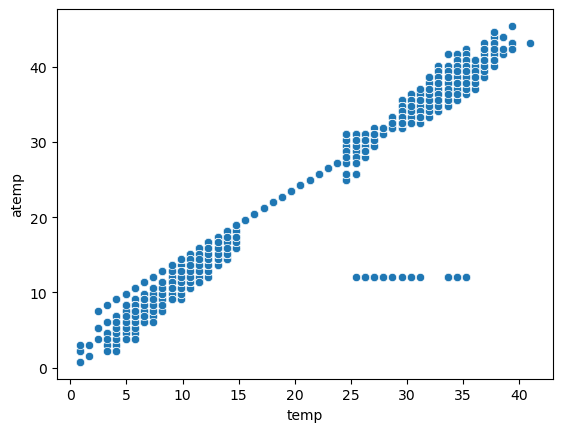

In [46]:
# Analyzing the interaction between temp and atemp
sns.scatterplot(x='temp', y='atemp', data=df_with_time_features_train)

In [47]:
# Removing temp vs atemp outliers
cond = ~((df_with_time_features_train['temp'] > 25) &
         (df_with_time_features_train['temp'] < 37) &
         (df_with_time_features_train['atemp'] > 10) &
         (df_with_time_features_train['atemp'] < 15))

df_with_time_features_train.drop(df_with_time_features_train[~cond].index, inplace=True)

In [48]:
# Removing rows where humidity == 0
df_with_time_features_train = df_with_time_features_train[df_with_time_features_train['humidity'] != 0]

In [49]:
# Removing rows where 'temp_vs_windspeed' > 1750
df_with_time_features_train = df_with_time_features_train[df_with_time_features_train['temp_vs_windspeed'] < 1750]

In [50]:
# Appling Isolation forest in the rest of the quantitative cols of df
X_if = df_with_time_features_train[quantitative_cols].values

iso = IsolationForest(
    n_estimators=100,
    contamination=0.005,
    random_state=42
)
df_with_time_features_train["if_outlier"] = iso.fit_predict(X_if)

# -1 = outlier, 1 = normal
df_with_time_features_train["if_outlier"] = df_with_time_features_train["if_outlier"].map({1:0, -1:1})
df_with_time_features_train.drop(df_with_time_features_train[df_with_time_features_train["if_outlier"] == 1].index, inplace=True)

In [51]:
print("Remaining rows:", df_with_time_features_train.shape[0])

Remaining rows: 10783


#8. Model Development and Evaluation

8.1 Baseline and Tree-Based Models (Random Forest, XGBoost, LightGBM)

8.2 Model Evaluation (Baseline Comparison)

8.3 Feature Selection with Feature Importances

8.4 Model Evaluation (After Feature Selection)

8.5 Hyperparameter Tuning

8.6 Model Evaluation (After Tuning)


In [52]:
df_train_final = df_with_time_features_train
df_test_final = df_with_time_features_test

In [53]:
df_train_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10783 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   season                 10783 non-null  int64  
 1   holiday                10783 non-null  int64  
 2   workingday             10783 non-null  int64  
 3   weather                10783 non-null  int64  
 4   temp                   10783 non-null  float64
 5   atemp                  10783 non-null  float64
 6   humidity               10783 non-null  int64  
 7   windspeed              10783 non-null  float64
 8   casual                 10783 non-null  int64  
 9   registered             10783 non-null  int64  
 10  count                  10783 non-null  int64  
 11  hour                   10783 non-null  int64  
 12  dayofweek              10783 non-null  int64  
 13  dayofmonth             10783 non-null  int64  
 14  dayofyear          

###8.1 Baseline and Tree-Based Models (Random Forest, XGBoost, LightGBM)

In [54]:
columns_to_remove = [
    'count', 'casual', 'registered',
    'temp_vs_humidity', 'temp_vs_windspeed',
    'humidity_vs_windspeed'] #, 'if_outlier'


features = (
    df_train_final
        .drop(columns=columns_to_remove)
        .select_dtypes(exclude='object')
        .columns
)

X = df_train_final[features]

In [55]:
# Targets
y = np.log1p(df_train_final[['registered', 'casual', 'count']])

In [56]:
# Baseline / mse by default
rf_base = RandomForestRegressor(random_state=42)

xgb_base = XGBRegressor(random_state=42)

lgbm_base = lgb.LGBMRegressor(random_state=42, verbosity=-1)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        shuffle=False,  # Following chronological order, even treating it as a pure regression problem
    )

In [58]:
# Even though we are predicting multiple targets (registered, casual, and count),
# they all come from the same observations and share the same feature matrix.
# Therefore, the train/test split must be performed only once on X (the features),
# and all target variables must follow this split using the same indices.
# Splitting each target separately would evaluate the models on different samples,
# making the results and metrics not directly comparable.
# This reasoning is independent of treating the problem as a time series.

In [59]:
# Training
rf_base_fit = rf_base.fit(X_train, y_train)

xgb_multi_fit = MultiOutputRegressor(xgb_base).fit(X_train, y_train)

lgbm_multi_fit = MultiOutputRegressor(lgbm_base).fit(X_train, y_train)

In [60]:
# Predicting
y_pred_rf_log = rf_base_fit.predict(X_test)

y_pred_xgb_log = xgb_multi_fit.predict(X_test)

y_pred_lgbm_log = lgbm_multi_fit.predict(X_test)

In [61]:
# Log inversion y_test
y_true = np.expm1(y_test)

In [62]:
# Log inversion predictions
y_pred_rf   = np.expm1(y_pred_rf_log)

y_pred_xgb  = np.expm1(y_pred_xgb_log)

y_pred_lgbm = np.expm1(y_pred_lgbm_log)

In [63]:
# Preparing predictions for RMSLE evaluation
results_rf   = pd.DataFrame(y_pred_rf,   columns=['registered', 'casual', 'count'])

results_xgb  = pd.DataFrame(y_pred_xgb,  columns=['registered', 'casual', 'count'])

results_lgbm = pd.DataFrame(y_pred_lgbm, columns=['registered', 'casual', 'count'])

#8.2 Model Evaluation (Baseline Comparison)

In [64]:
# Registered RMSLE
rmsle_reg_rf = processing.rmsle(y_true['registered'], results_rf['registered'])
rmsle_reg_xgb = processing.rmsle(y_true['registered'], results_xgb['registered'])
rmsle_reg_lgbm = processing.rmsle(y_true['registered'], results_lgbm['registered'])

print("RMSLE rf REGISTERED Base:", f"{rmsle_reg_rf:.2f}")
print("RMSLE xgb REGISTERED Base:", f"{rmsle_reg_xgb:.2f}")
print("RMSLE lgbm REGISTERED Base:", f"{rmsle_reg_lgbm:.2f}")

RMSLE rf REGISTERED Base: 0.40
RMSLE xgb REGISTERED Base: 0.31
RMSLE lgbm REGISTERED Base: 0.32


In [65]:
# Casual RMSLE
rmsle_cas_rf = processing.rmsle(y_true['casual'], results_rf['casual'])
rmsle_cas_xgb = processing.rmsle(y_true['casual'], results_xgb['casual'])
rmsle_cas_lgbm = processing.rmsle(y_true['casual'], results_lgbm['casual'])

print("RMSLE rf CASUAL Base:", f"{rmsle_cas_rf:.2f}")
print("RMSLE xgb CASUAL Base:", f"{rmsle_cas_xgb:.2f}")
print("RMSLE lgbm CASUAL Base:", f"{rmsle_cas_lgbm:.2f}")

RMSLE rf CASUAL Base: 0.52
RMSLE xgb CASUAL Base: 0.50
RMSLE lgbm CASUAL Base: 0.49


In [68]:
# Count RMSLE
rmsle_cnt_rf = processing.rmsle(y_true['count'], results_rf['count'])
rmsle_cnt_xgb = processing.rmsle(y_true['count'], results_xgb['count'])
rmsle_cnt_lgbm = processing.rmsle(y_true['count'], results_lgbm['count'])

print("RMSLE rf COUNT Base:", f"{rmsle_cnt_rf:.2f}")
print("RMSLE xgb COUNT Base:", f"{rmsle_cnt_xgb:.2f}")
print("RMSLE lgbm COUNT Base:", f"{rmsle_cnt_lgbm:.2f}")

RMSLE rf COUNT Base: 0.39
RMSLE xgb COUNT Base: 0.33
RMSLE lgbm COUNT Base: 0.32


In [69]:
# Chosen model = LightGBM

Text(0.5, 1.0, 'Residuals vs Predicted — Count (Random Forest)')

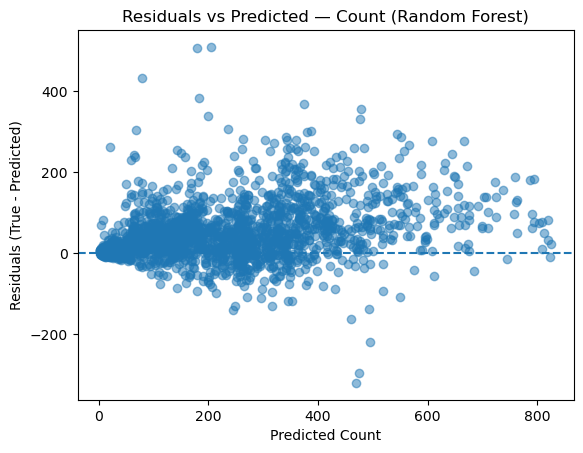

In [70]:
# Residuals COUNT Random Forest Baseline
residuals_cnt_rf = y_true['count'].values - results_rf['count'].values

plt.scatter(results_rf['count'].values, residuals_cnt_rf, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel('Predicted Count')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residuals vs Predicted — Count (Random Forest)')

# The plot shows that the residuals are now randomly and uniformly distributed
# around the zero line, confirming a significant improvement compared to the
# initial funnel-shaped pattern.

Text(0.5, 1.0, 'Residuals vs Predicted — Count (LightGBM)')

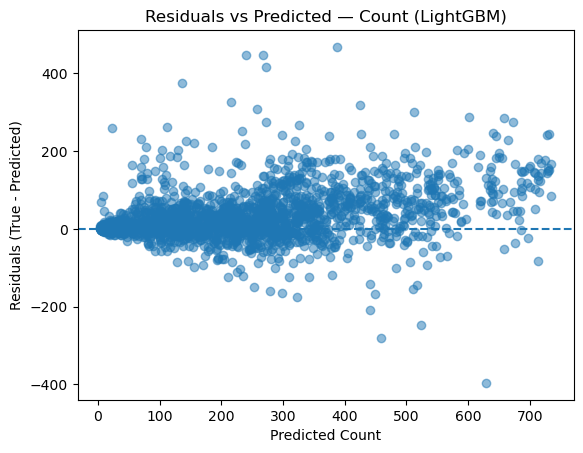

In [71]:
# Residuals COUNT LightGBM Baseline
residuals_cnt_lgbm = y_true['count'].values - results_lgbm['count'].values

plt.scatter(results_lgbm['count'].values, residuals_cnt_lgbm, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel('Predicted Count')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residuals vs Predicted — Count (LightGBM)')

###8.3 Feature Selection with Feature Importances

In [72]:
# -------------- FEATURE SELECTION WITH FEATURE IMPORTANCES -------------- #

target_names = y.columns
feature_names = X.columns

feature_importance_per_target = {}

for i, individual_model in enumerate(lgbm_multi_fit.estimators_):
    target_col = target_names[i]
    importances = individual_model.feature_importances_
    feature_importance_per_target[target_col] = importances

df_importances = pd.DataFrame(feature_importance_per_target, index=feature_names)
print(df_importances)
print(feature_importance_per_target)

                 registered  casual  count
season                   10      14     12
holiday                  29      26     32
workingday              109      95    108
weather                 108     100    135
temp                    193     236    202
atemp                   155     197    171
humidity                284     329    274
windspeed               146     184    129
hour                    823     640    846
dayofweek               297     260    299
dayofmonth              171     240    169
dayofyear               424     480    386
weekofyear               49      51     44
month                     0       0      0
quarter                   0       0      0
year                    144      92    114
weekend                   0       0      0
special_holiday           0       0      0
peak                     58      56     79
time_group                0       0      0
if_outlier                0       0      0
{'registered': array([ 10,  29, 109, 108, 193, 155, 28

In [73]:
selected_features_reg = df_importances[df_importances['registered'] > 0].index.tolist()

selected_features_cas = df_importances[df_importances['casual'] > 0].index.tolist()

selected_features_cnt = df_importances[df_importances['count'] > 0].index.tolist()

In [74]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X[selected_features_reg],
    y['registered'],
    test_size=0.2,
    random_state=42)

X_train_cas, X_test_cas, y_train_cas, y_test_cas = train_test_split(
    X[selected_features_cas],
    y['casual'],
    test_size=0.2,
    random_state=42)

X_train_cnt, X_test_cnt, y_train_cnt, y_test_cnt = train_test_split(
    X[selected_features_cnt],
    y['count'],
    test_size=0.2,
    random_state=42)

In [75]:
model_reg_lgbm = clone(lgbm_base)
model_cas_lgbm = clone(lgbm_base)
model_cnt_lgbm = clone(lgbm_base)

In [76]:
# Training lgbm for each target FS
lgbm_reg_fit_fs = model_reg_lgbm.fit(X_train_reg, y_train_reg)

lgbm_cas_fit_fs = model_cas_lgbm.fit(X_train_cas, y_train_cas)

lgbm_cnt_fit_fs = model_cnt_lgbm.fit(X_train_cnt, y_train_cnt)

In [77]:
# Predicting on test set FS
y_pred_reg_log_fs = lgbm_reg_fit_fs.predict(X_test_reg)

y_pred_cas_log_fs = lgbm_cas_fit_fs.predict(X_test_cas)

y_pred_cnt_log_fs = lgbm_cnt_fit_fs.predict(X_test_cnt)

In [78]:
# Log inversion FS
y_pred_reg_fs = np.expm1(y_pred_reg_log_fs)

y_pred_cas_fs = np.expm1(y_pred_cas_log_fs)

y_pred_cnt_fs = np.expm1(y_pred_cnt_log_fs)

In [79]:
# Log inversion y_test FS
y_true_reg = np.expm1(y_test_reg)
y_true_cas = np.expm1(y_test_cas)
y_true_cnt = np.expm1(y_test_cnt)

###8.4 Model Evaluation (After Feature Selection)

In [80]:
# RMSE FS
rmsle_reg_fs = processing.rmsle(y_true_reg, y_pred_reg_fs)
rmsle_cas_fs = processing.rmsle(y_true_cas, y_pred_cas_fs)
rmsle_cnt_fs = processing.rmsle(y_true_cnt, y_pred_cnt_fs)

print("RMSLE Registered FS:", f"{rmsle_reg_fs:.2f}")
print("RMSLE Casual FS:", f"{rmsle_cas_fs:.2f}")
print("RMSLE Count FS:", f"{rmsle_cnt_fs:.2f}")

RMSLE Registered FS: 0.28
RMSLE Casual FS: 0.46
RMSLE Count FS: 0.28


###8.5 Hyperparameter Tuning

In [81]:
study_reg = optuna.create_study(direction='minimize')

study_reg.optimize(lambda trial: processing.objective(trial, X_train_reg, y_train_reg), n_trials=30)

best_params_reg = study_reg.best_params

print("Best hyperparameters found:", best_params_reg)

[I 2026-01-23 17:23:55,558] A new study created in memory with name: no-name-4db88a43-604f-453a-8fec-854684b39406
[I 2026-01-23 17:24:09,965] Trial 0 finished with value: 0.2911720994415145 and parameters: {'num_leaves': 965, 'max_depth': 7, 'min_data_in_leaf': 57, 'learning_rate': 0.009699007734742962, 'colsample_bytree': 0.6973738425041557, 'n_estimators': 784}. Best is trial 0 with value: 0.2911720994415145.
[I 2026-01-23 17:24:15,538] Trial 1 finished with value: 0.2840515070507686 and parameters: {'num_leaves': 483, 'max_depth': 3, 'min_data_in_leaf': 81, 'learning_rate': 0.08767494404022079, 'colsample_bytree': 0.9243639561312482, 'n_estimators': 932}. Best is trial 1 with value: 0.2840515070507686.
[I 2026-01-23 17:24:19,675] Trial 2 finished with value: 0.9579073348545056 and parameters: {'num_leaves': 257, 'max_depth': 3, 'min_data_in_leaf': 84, 'learning_rate': 0.006532130156582168, 'colsample_bytree': 0.05079769245428261, 'n_estimators': 734}. Best is trial 1 with value: 0.2

Best hyperparameters found: {'num_leaves': 64, 'max_depth': 15, 'min_data_in_leaf': 8, 'learning_rate': 0.03252383669297727, 'colsample_bytree': 0.9829855378171066, 'n_estimators': 536}


In [ ]:
study_cas = optuna.create_study(direction='minimize')

study_cas.optimize(lambda trial: processing.objective(trial, X_train_cas, y_train_cas), n_trials=30)

best_params_cas = study_cas.best_params

print("Best hyperparameters found:", best_params_cas)

[I 2026-01-23 17:27:41,547] A new study created in memory with name: no-name-fe3150a5-8a67-47c4-ad38-f6b23d7820ba
[I 2026-01-23 17:27:51,559] Trial 0 finished with value: 0.477933303162584 and parameters: {'num_leaves': 304, 'max_depth': 7, 'min_data_in_leaf': 1, 'learning_rate': 0.07376262303228946, 'colsample_bytree': 0.948751313731643, 'n_estimators': 669}. Best is trial 0 with value: 0.477933303162584.
[I 2026-01-23 17:28:16,432] Trial 1 finished with value: 0.46566012960297504 and parameters: {'num_leaves': 306, 'max_depth': 13, 'min_data_in_leaf': 22, 'learning_rate': 0.010337485481121362, 'colsample_bytree': 0.9901762825724165, 'n_estimators': 967}. Best is trial 1 with value: 0.46566012960297504.
[I 2026-01-23 17:28:18,103] Trial 2 finished with value: 0.862894366771237 and parameters: {'num_leaves': 468, 'max_depth': 8, 'min_data_in_leaf': 37, 'learning_rate': 0.026318554249072004, 'colsample_bytree': 0.14524101313966017, 'n_estimators': 164}. Best is trial 1 with value: 0.465

In [ ]:
study_cnt = optuna.create_study(direction='minimize')

study_cnt.optimize(lambda trial: processing.objective(trial, X_train_cnt, y_train_cnt), n_trials=30)

best_params_cnt = study_cnt.best_params

print("Best hyperparameters found:", best_params_cnt)

In [ ]:
# lgbm training with optimized hyperparameters
lgbm_reg_ht = lgb.LGBMRegressor(**best_params_reg)

lgbm_cas_ht = lgb.LGBMRegressor(**best_params_cas)

lgbm_cnt_ht = lgb.LGBMRegressor(**best_params_cnt)

In [ ]:
# Training lgbm for each target HT
lgbm_reg_fit_ht = lgbm_reg_ht.fit(X_train_reg, y_train_reg)

lgbm_cas_fit_ht = lgbm_cas_ht.fit(X_train_cas, y_train_cas)

lgbm_cnt_fit_ht = lgbm_cnt_ht.fit(X_train_cnt, y_train_cnt)

In [ ]:
# Predicting on test set HT
y_pred_reg_log_ht = lgbm_reg_fit_ht.predict(X_test_reg)

y_pred_cas_log_ht = lgbm_cas_fit_ht.predict(X_test_cas)

y_pred_cnt_log_ht = lgbm_cnt_fit_ht.predict(X_test_cnt)

In [ ]:
# Log inversion HT
y_pred_reg_ht = np.expm1(y_pred_reg_log_ht)

y_pred_cas_ht = np.expm1(y_pred_cas_log_ht)

y_pred_cnt_ht = np.expm1(y_pred_cnt_log_ht)

### 8.6 Model Evaluation (After Tuning)

In [ ]:
# RMSLE HT
rmsle_reg_ht = processing.rmsle(y_true_reg, y_pred_reg_ht)
rmsle_cas_ht = processing.rmsle(y_true_cas, y_pred_cas_ht)
rmsle_cnt_ht = processing.rmsle(y_true_cnt, y_pred_cnt_ht)

print("RMSLE Registered HT:", f"{rmsle_reg_ht:.2f}")
print("RMSLE Casual HT:", f"{rmsle_cas_ht:.2f}")
print("RMSLE Count HT:", f"{rmsle_cnt_ht:.2f}")

In [ ]:
# RMSLE - LGBM baseline vs. after feature selection and hyperparameter tuning

improvement_reg = processing.rmsle_improvement_pct(rmsle_reg_lgbm, rmsle_reg_ht)
improvement_cas = processing.rmsle_improvement_pct(rmsle_cas_lgbm, rmsle_cas_ht)
improvement_cnt = processing.rmsle_improvement_pct(rmsle_cnt_lgbm, rmsle_cnt_ht)

print(f"Registered RMSLE improvement: {improvement_reg:.2f}%")
print(f"Casual RMSLE improvement: {improvement_cas:.2f}%")
print(f"Count RMSLE improvement: {improvement_cnt:.2f}%")

# Feature selection and hyperparameter tuning led to consistent relative
# reductions in RMSLE across all targets when compared to the baseline model

In [ ]:
# Residuals Registered HT
residuals_reg = y_true_reg - y_pred_reg_ht

plt.scatter(y_pred_reg_ht, residuals_reg, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Registered')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residuals vs. Predicted Values — Registered')

In [ ]:
# Residuals Casual HT
residuals_cas = y_true_cas - y_pred_cas_ht

plt.scatter(y_pred_cas_ht, residuals_cas, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Registered')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residuals vs. Predicted Values — Registered')

In [ ]:
# Residuals Count HT
residuals_cnt = y_true_cnt - y_pred_cnt_ht

plt.scatter(y_pred_cnt_ht, residuals_cnt, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Count')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residuals vs. Predicted Values — Count')

# Compared to the residual distribution of the baseline LightGBM model, the
# previous version showed a considerable overestimation. After feature selection
# and hyperparameter tuning, the residuals exhibit a more uniform and symmetric
# distribution around the zero line, indicating improved predictive stability

#Test Data Forecasting

In [ ]:
# df test Forecasting
# ---------------- REGISTERED ---------------- #

X_reg = df_train_final[selected_features_reg]
y_reg = np.log1p(df_train_final['registered'])

model_reg = lgb.LGBMRegressor(**best_params_reg)

model_reg.fit(X_reg, y_reg)

y_reg_pred_log = model_reg.predict(df_test_final[selected_features_reg])

y_reg_pred = np.expm1(y_reg_pred_log)

# ---------------- CASUAL ---------------- #

x_cas = df_train_final[selected_features_cas]
y_cas = np.log1p(df_train_final['casual'])

model_cas = lgb.LGBMRegressor(**best_params_cas)

model_cas.fit(x_cas, y_cas)

y_cas_pred_log = model_cas.predict(df_test_final[selected_features_cas])

y_cas_pred = np.expm1(y_cas_pred_log)

# ---------------- COUNT ---------------- #

y_cnt_pred = y_reg_pred + y_cas_pred

In [ ]:
"""# ---------------- COUNT ---------------- #

x_cnt = df_train_final[selected_features_cnt]
y_cnt = np.log1p(df_train_final['count'])

model_cnt = lgb.LGBMRegressor(**best_params_cnt)

model_cnt.fit(x_cnt, y_cnt)

y_cnt_pred_log = model_cnt.predict(df_test_final[selected_features_cnt])

y_cnt_pred = np.expm1(y_cnt_pred_log)"""

In [ ]:
# Merging train and test dfs
df_full = pd.concat([df_with_time_features_train, df_with_time_features_test], sort=False)
df_full.sort_index(inplace=True)

mask_train = df_full['count'].notna()
mask_test = df_full['count'].isna()

In [ ]:
# Combined count column
df_plot = df_full.copy()

# Assign actual count values for the training period
df_plot.loc[mask_train, 'count_combined'] = df_plot.loc[mask_train, 'count']

# Assign predicted values for the test period
df_plot.loc[mask_test, 'count_combined'] = y_cnt_pred


processing.plot_daily_train_test(df_plot, 'count_combined', mask_train, mask_test)

In [ ]:
"""
Exporting test set predictions to a csv file for final submission
"""

# Using strftime to ensure the datetime index is formatted correctly as a string
df_test_export = pd.DataFrame({
    'datetime': df_test_final.index.strftime('%Y-%m-%d %H:%M:%S'),
    'count': y_cnt_pred
})

output_filename = 'BIKE-SHARING-DEMAND-FORECASTING.csv'
df_test_export.to_csv(
    output_filename,
    index=False
)

print(f"CSV file successfully created: {output_filename}")